### Import Modules

In [116]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

# set plot style
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [34]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

### Import Data

In [117]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

### Data Overview

In [118]:
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [119]:
train_df.shape

(15819, 3)

In [120]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [121]:
test_df.shape

(10546, 2)

In [122]:
train_df.set_index('tweetid', inplace=True)  

In [123]:
train_df.head()

,sentiment,message
tweetid,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...
126103,1,It's not like we lack evidence of anthropogeni...
698562,2,RT @RawStory: Researchers say we have three ye...
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


In [124]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [125]:
train_df['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

In [126]:
train_df['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

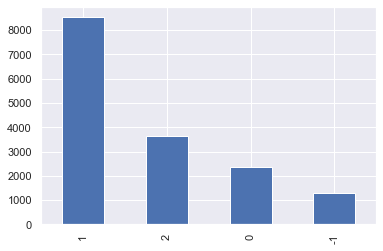

In [127]:
train_df['sentiment'].value_counts().plot(kind = 'bar')

In [128]:
train_df.isnull().sum()

sentiment    0
message      0
dtype: int64

In [129]:
test_df.isnull().sum()

message    0
tweetid    0
dtype: int64

## Text Cleaning

### Remove noise

In [130]:
# removing the web-url
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
train_df['message'] = train_df['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)
test_df['message'] = test_df['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [131]:
train_df.head()

,sentiment,message
tweetid,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...
126103,1,It's not like we lack evidence of anthropogeni...
698562,2,RT @RawStory: Researchers say we have three ye...
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


In [132]:
# making everything lower case
train_df['message'] = train_df['message'].str.lower()
test_df['message'] = test_df['message'].str.lower()

In [133]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [134]:
# remove punctuation
def remove_punctuation(message):
    return ''.join([m for m in message if m not in string.punctuation])

In [135]:
train_df['message'] = train_df['message'].apply(remove_punctuation)
test_df['message'] = test_df['message'].apply(remove_punctuation)

In [136]:
train_df.head()

,sentiment,message
tweetid,,
625221,1,polyscimajor epa chief doesnt think carbon dio...
126103,1,its not like we lack evidence of anthropogenic...
698562,2,rt rawstory researchers say we have three year...
573736,1,todayinmaker wired 2016 was a pivotal year in...
466954,1,rt soynoviodetodas its 2016 and a racist sexis...


In [137]:
test_df.head()

,message,tweetid
0,europe will now be looking to china to make su...,169760
1,combine this with the polling of staffers re c...,35326
2,the scary unimpeachable evidence that climate ...,224985
3,karoli morgfair osborneink dailykos \nputin go...,476263
4,rt fakewillmoore female orgasms cause global w...,872928


### Split the data into train & test sets

In [138]:
from sklearn.model_selection import train_test_split

In [139]:
X = train_df['message']
y = train_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [140]:
from sklearn.feature_extraction.text import CountVectorizer

In [141]:
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(9491, 17986)

In [142]:
# Transform Counts to Frequencies with Tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(9491, 17986)

In [143]:
# Combine Steps with TfidVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train) # remember to use the original X_train set
X_train_tfidf.shape

(9491, 17986)

### Train a Classifier

In [144]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train_tfidf,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [145]:
# Build a Pipeline
from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.svm import LinearSVC

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

### Test the classifier and display results

In [146]:
# Form a prediction set
predictions = text_clf.predict(X_test)

In [147]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[ 229   80  189   23]
 [  44  363  403   84]
 [  51  166 2965  294]
 [   8   26  284 1119]]


In [148]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       0.69      0.44      0.54       521
           0       0.57      0.41      0.47       894
           1       0.77      0.85      0.81      3476
           2       0.74      0.78      0.76      1437

    accuracy                           0.74      6328
   macro avg       0.69      0.62      0.64      6328
weighted avg       0.73      0.74      0.73      6328



In [149]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.7389380530973452


In [150]:
# Predictions on the test dataframe
pred = text_clf.predict(test_df['message'])

In [151]:
pred

array([1, 1, 1, ..., 2, 0, 1], dtype=int64)

In [38]:
submission = pd.DataFrame({'tweetid':test_df['tweetid'],'sentiment':pred})

In [39]:
submission.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0


filename = 'results2.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

### Random Forest Classifier

In [156]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train_tfidf,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [157]:
# Build a Pipeline
from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.svm import LinearSVC

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', RandomForestClassifier()),])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [158]:
# Form a prediction set
predictions = text_clf.predict(X_test)

In [159]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[  72   52  381   16]
 [   3  261  569   61]
 [   0   84 3066  326]
 [   2   18  398 1019]]


In [160]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       0.94      0.14      0.24       521
           0       0.63      0.29      0.40       894
           1       0.69      0.88      0.78      3476
           2       0.72      0.71      0.71      1437

    accuracy                           0.70      6328
   macro avg       0.74      0.51      0.53      6328
weighted avg       0.71      0.70      0.66      6328



In [161]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.6981668773704172
